<a href="https://colab.research.google.com/github/cksdnr1/PyTorchPJ/blob/main/3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try: 
            print(f'Shape:{var.shape}')
        except : 
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}') 

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics torchviz 

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import pytorch_lightning as pl

from pytorch_lightning.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary 


from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data 
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.__version__,pl.__version__

('1.13.1+cu116', '2.0.0')

In [ ]:
## GPU check
torch.cuda.is_available(),torch.cuda.device_count(),torch.cuda.current_device(),torch.cuda.device(0),torch.cuda.get_device_name(0)

(True, 1, 0, <torch.cuda.device at 0x7f4ce0566040>, 'Tesla T4')

## MLP, CNN Parameter 비교

In [ ]:
#device ='cuda:0'

In [ ]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), # 255로 나누어주고 tensor로 변환
])

_batch_size = 128
download_root = ''
train_dataset = MNIST(download_root, train=True, download=True, transform=mnist_transform)
test_dataset = MNIST(download_root, train=False, download=True, transform=mnist_transform)
trainDataLoader = DataLoader(train_dataset, _batch_size, True) 
valDataLoader = DataLoader(test_dataset, _batch_size, False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



[] Shapetorch.Size([60000, 28, 28]), <class 'torch.Tensor'>
[] Shapetorch.Size([60000]), <class 'torch.Tensor'>


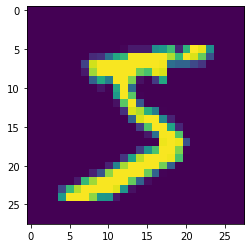

In [ ]:
pst(trainDataLoader.dataset.data)
pst(trainDataLoader.dataset.targets)
plt.imshow(trainDataLoader.dataset.data[0])

In [ ]:
batch_n = len(trainDataLoader.dataset.data) // _batch_size
batch_n 

468

### MLP Model 

In [ ]:
# MLP model
class MLP(pl.LightningModule):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(  # Container 
            nn.Flatten(),
            nn.Linear(784, 384),
            nn.ReLU(),
            nn.Linear(384, 10))
            
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        if ((batch_idx+1)%batch_n)==0: print(f'Bachs:{batch_idx:04d}, Loss:{loss:0.4f}, Acc:{acc:0.4f}')
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

mlp = MLP()
summary(mlp, input_size=(_batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Flatten: 2-1                      [128, 784]                --
│    └─Linear: 2-2                       [128, 384]                301,440
│    └─ReLU: 2-3                         [128, 384]                --
│    └─Linear: 2-4                       [128, 10]                 3,850
Total params: 305,290
Trainable params: 305,290
Non-trainable params: 0
Total mult-adds (M): 39.08
Input size (MB): 0.40
Forward/backward pass size (MB): 0.40
Params size (MB): 1.22
Estimated Total Size (MB): 2.03

In [ ]:
%%time
mlp = MLP()

_epochs = 10
name="mlp"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=_epochs, logger=logger, accelerator="auto",
                     limit_train_batches=0.4, limit_val_batches=0.2)
trainer.fit(mlp, trainDataLoader, valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 305 K 
--------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.221     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 46.6 s, sys: 415 ms, total: 47 s
Wall time: 55.1 s


In [ ]:
v_num = logger.version  
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv') 
df = history.groupby('epoch').last().drop('step', axis=1) 

MaxAcc:[ 0.9692708253860474 ]


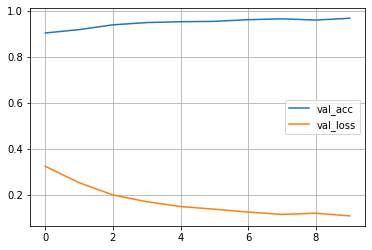

In [ ]:
import matplotlib.pylab as plt

print('MaxAcc:[',df['val_acc'].max(),']')

plt.plot(df['val_acc'], linestyle='-', label="val_acc")
plt.plot(df['val_loss'], linestyle='-', label="val_loss")

#plt.ylim(0.2,0.95)
plt.legend()
plt.grid()
plt.show() 

### CNN Model

In [ ]:
# Convolutional model
loss_f = nn.CrossEntropyLoss()
class CNN(pl.LightningModule):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 48, (3, 3), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(48*6*6, 10)
            )
        
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        if ((batch_idx+1)%batch_n)==0: 
          print(f'Bachs:{batch_idx:04d}, Loss:{loss:0.4f}, Acc:{acc:0.4f}')
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

cnn = CNN()
summary(cnn, input_size=(_batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 32, 13, 13]         320
│    └─ReLU: 2-2                         [128, 32, 13, 13]         --
│    └─Conv2d: 2-3                       [128, 48, 6, 6]           13,872
│    └─ReLU: 2-4                         [128, 48, 6, 6]           --
│    └─Flatten: 2-5                      [128, 1728]               --
│    └─Linear: 2-6                       [128, 10]                 17,290
Total params: 31,482
Trainable params: 31,482
Non-trainable params: 0
Total mult-adds (M): 73.06
Input size (MB): 0.40
Forward/backward pass size (MB): 7.32
Params size (MB): 0.13
Estimated Total Size (MB): 7.84

In [ ]:
%%time 
cnn = CNN()

name="cnn"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=_epochs, logger=logger, accelerator="auto",
                     limit_train_batches=0.4,limit_val_batches=0.2)                     
trainer.fit(cnn, trainDataLoader, val_dataloaders=valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 31.5 K
--------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 42.5 s, sys: 399 ms, total: 42.9 s
Wall time: 43.9 s


In [ ]:
v_num = logger.version ## cnn.get_progress_bar_dict()['v_num'] 
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv') 
df = history.groupby('epoch').last().drop('step', axis=1) 

MaxAcc:[ 0.9760416746139526 ]


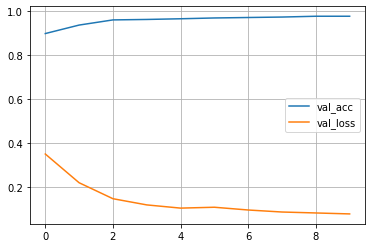

In [ ]:
import matplotlib.pylab as plt

print('MaxAcc:[',df['val_acc'].max(),']')

plt.plot(df['val_acc'], linestyle='-', label="val_acc")
plt.plot(df['val_loss'], linestyle='-', label="val_loss")

#plt.ylim(0.2,0.95)
plt.legend()
plt.grid() 
plt.show() 

# 실습과제
LeNet-5와 유사한 모델을 만들어보자
- 모델을 개선하여 10epoch 학습 최고 성능이 되도록 하자  

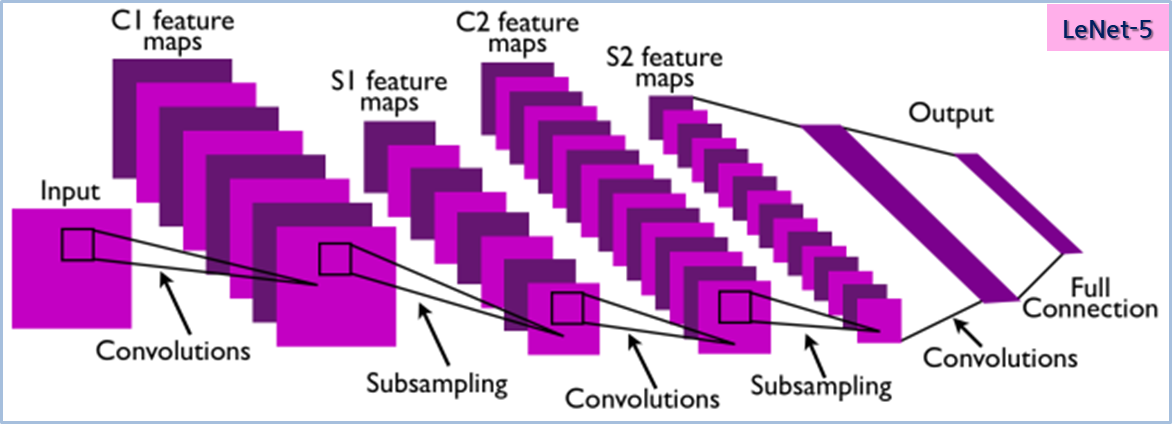

In [ ]:
# LeNet like model
class LeNet_like(pl.LightningModule):
    def __init__(self):
        super(LeNet_like, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 8, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
##            nn.Conv2d(8, 8, (3, 3), padding=1),
##
            nn.Flatten(),
##            nn.Linear(64*3*3, 10)
        )          
    def forward(self, x):
        out = self.layers(x)
        return out
       
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        if ((batch_idx+1)%batch_n)==0: 
          print(f'Bachs:{batch_idx:04d}, Loss:{loss:0.4f}, Acc:{acc:0.4f}')
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

LeNet = LeNet_like() 
summary(LeNet, input_size=(_batch_size, 1, 28, 28))

In [ ]:
LeNet = LeNet_like()

name="lenet"  
logger = pl.loggers.CSVLogger("logs", name=name) 
trainer = pl.Trainer(max_epochs=_epochs, logger=logger, accelerator="auto",
                     limit_train_batches=0.4,limit_val_batches=0.2)                     
trainer.fit(LeNet, trainDataLoader, valDataLoader) 

In [ ]:
v_num = logger.version ## LeNet.get_progress_bar_dict()['v_num'] 
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv') 
df = history.groupby('epoch').last().drop('step', axis=1) 

In [ ]:
import matplotlib.pylab as plt

print('MaxAcc:[',df['val_acc'].max(),']')

plt.plot(df['val_acc'], linestyle='-', label="val_acc")
plt.plot(df['val_loss'], linestyle='-', label="val_loss")
# plt.plot(df2['val_acc'], linestyle='--', label="_val_acc")
# plt.plot(df2['val_loss'], linestyle='--', label="_val_loss")

#plt.ylim(0.2,0.95)
plt.legend()
plt.grid()
plt.show() 